# A power-based EMG segmentation
This method estimated movements onsets represented by EMG signal with no prior knowledge of experiment settings. First, the energy of a window of signal was calculated. Such calculation rolls the whole signal with a steo. The energy is defined as the sum of absolute value (one can also used $\int_t signal(t) dt$). Second, the index of window whose energy exceed the threshold were retrived. The threshold was set as 0.5 quantile. Finally, the visualization is done thanks to mne.

In [ ]:
#Single channel segmentation, two channels emg6 and emg9 were selected to indicate push and pull movement onset
def firstOnsetD(possibleOnsets):
    '''
    This function detects the first value of a arithemic sequence. For a movement, the index obtained in second step is 
    indeed a arithemic sequence since the step is fixed
    '''
    n=len(possibleOnsets)
    st_idx = 0
    onsets = []
    while st_idx < n-1:
        end = st_idx + 1
        dif = possibleOnsets[end] - possibleOnsets[st_idx]
        while end < n - 1 and possibleOnsets[end + 1] - possibleOnsets[end] == dif:
            end += 1
        onsets.append(possibleOnsets[st_idx])
        st_idx = end+1
    return onsets

######################## Read mne.io.raw object as input ##############################
import numpy as np
raw2cut = raw_hybrid.copy()
raw2cut = raw2cut.pick_channels(['emg6'])

############### Parameters ##########################

windowLen = 1500 # related to the duration of a movement
step = 100 # equivalent to resolution


# rolling window on df
df = raw2cut.to_data_frame()['emg6'].abs()        ########## getting absolute value of the EMG channel
emgEnergy = df.rolling(windowLen, win_type='boxcar').sum().dropna()[::step]
possibleOnsets =np.array(emgEnergy[emgEnergy>emgEnergy.quantile(0.5)].index.tolist())-windowLen 
###### Obataining the idx of all window that exceed the threshold

# detection of the onset in arithemic sequences.
onsets =np.array(firstOnsetD(possibleOnsets))/sfreq  #related rto sampling rate of EMG
descriptions = ['movement1Onset']*len(onsets)

############################ Extention ################################
# if the movement was done forwards and backwords, second channel needs to be selected to detect the backwords movement (here 'emg9')
raw2cut = raw_hybrid.copy()
raw2cut = raw2cut.pick_channels(['emg9'])
df = raw2cut.to_data_frame()['emg9'].abs()
emgEnergy = df.rolling(windowLen, win_type='boxcar').sum().dropna()[::step]
possibleOnsets =np.array(emgEnergy[emgEnergy>emgEnergy.quantile(0.5)].index.tolist())-windowLen
inverseMovementOnsets=np.array(firstOnsetD(possibleOnsets))/sfreq

################################ Visualization using mne #####################
onsets = np.concatenate((onsets,inverseMovementOnsets))
durations = np.zeros_like(onsets)
descriptions =np.concatenate(( descriptions, ['movement2Onset']*len(inverseMovementOnsets)))
annot = mne.Annotations(onset=onsets, duration=durations,
                                    description=descriptions,
                                    orig_time=raw2cut.info['meas_date'])
#change to raw2cut see effetcs
raw_validate = raw_hybrid.copy()
raw_validate = raw_validate.pick_types(emg=True)
raw_validate.set_annotations(annot)
raw_validate.plot()
#thresholding

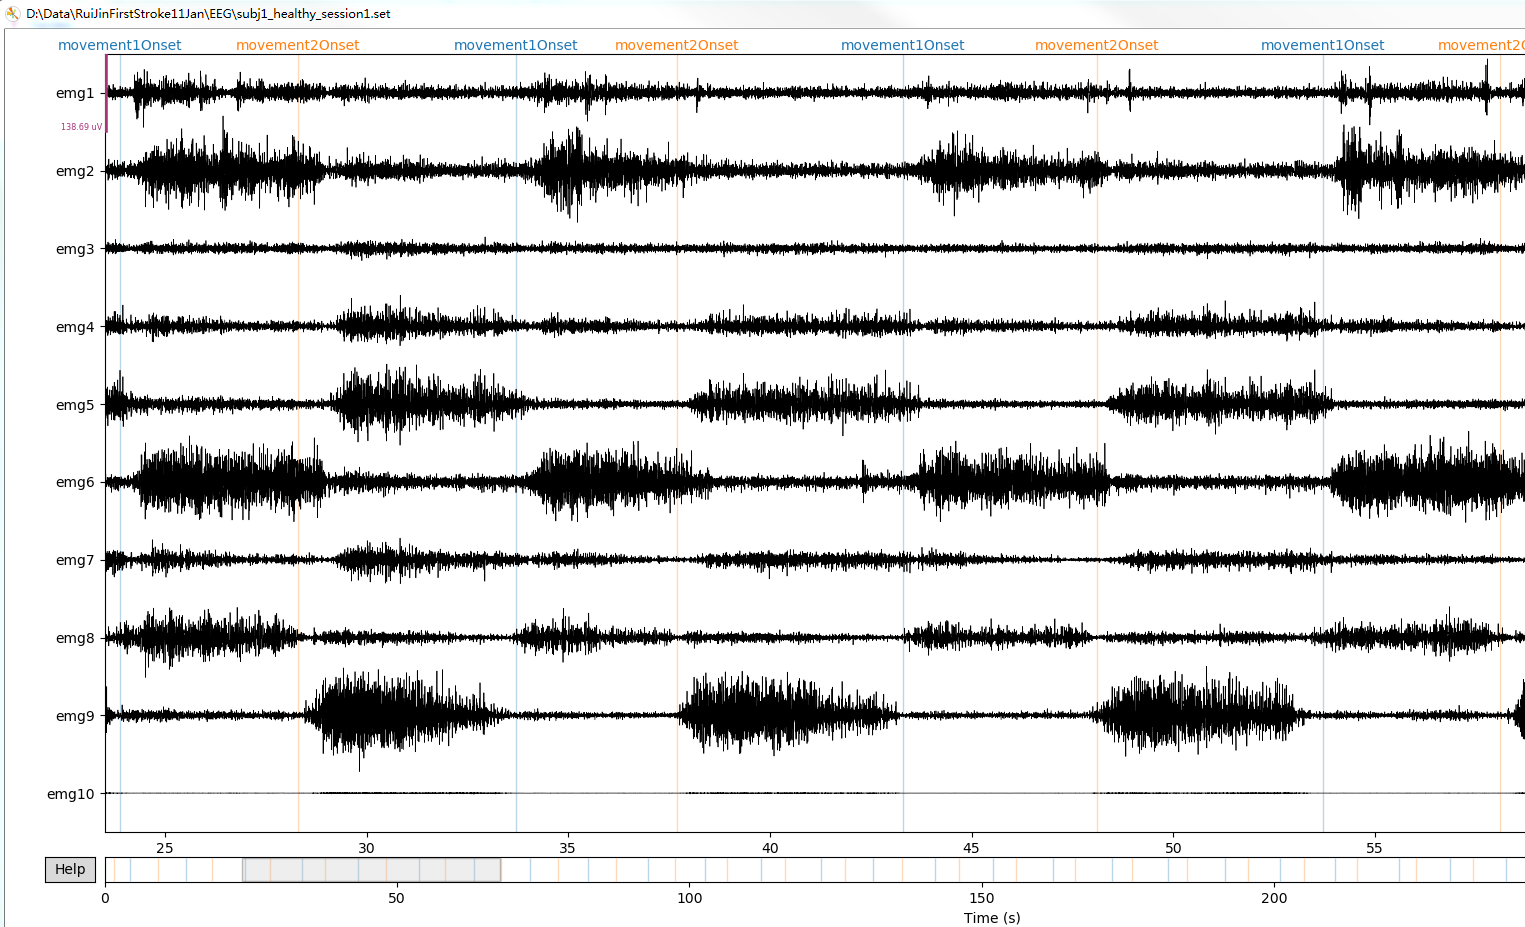

In [2]:
from IPython.display import Image
Image("EMG_segmentationSample.png")